In [ ]:
################################################################################
# File: qugel_circuit.py
# Author: Bolzmann
# Project: Qugel
# Description: This Python file implements a quantum circuit for image convolution
#              using PennyLane. It applies a series of quantum gates on patches
#              of an input image and visualizes the measurement results.
################################################################################

Convolved image:torch.Size([4096])
Original image - Min value: 0.13333334028720856, Max value: 0.8549019694328308
Resized CV image - Min value: 0.13333334028720856, Max value: 0.8549019694328308
Convolved image - Min value: -0.9646366238594055, Max value: 0.5614892244338989


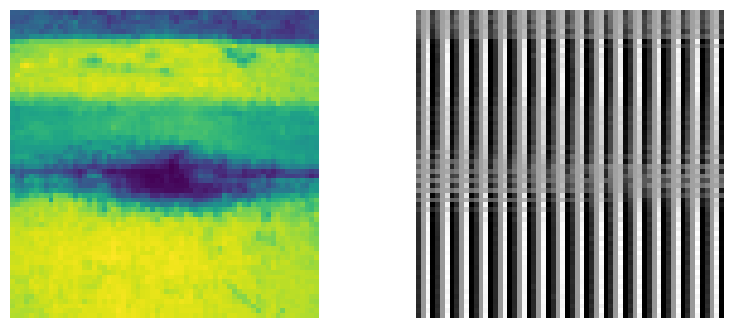

5it [00:16,  3.29s/it]

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np

from torchvision.datasets import ImageFolder

import pennylane as qml
from pennylane import numpy as np
from tqdm import tqdm
from IPython.display import display, clear_output

from qugel.qgates import *

# Constants
patch_size = 2
img_w = 64
rgb_c = 1  # Number of channels in the image (RGB)
batch_size = 32

n_qubits = patch_size ** 2 * rgb_c
wires = n_qubits
num_classes = 2
data_dir = "./datasets/ba"

# Set device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

dev4 = qml.device('default.qubit', wires=n_qubits)


@qml.qnode(dev4)
def QuantEncodingCirc(phi):
    """
    Quantum circuit for image convolution.

    This function applies a series of quantum gates on an input patch and
    returns the measurement results of the circuit.

    Args:
        phi (array-like): Input patch.

    Returns:
        array: Measurement results of the circuit.
    """
    Q_encoding_block(phi, n_qubits)    
    Q_quanvol_block_A(phi, n_qubits, 1)

    exp_vals = [qml.expval(qml.PauliZ(position)) for position in range(wires)]
    return exp_vals


# Dataset and dataloader
transform_list = [transforms.Resize((img_w, img_w))]  # Resize images to a fixed size

if rgb_c == 1:
    transform_list.append(transforms.Grayscale())  # Convert images to grayscale

transform_list.append(transforms.ToTensor())  # Convert images to tensors

data_transform = transforms.Compose(transform_list)

dataset = ImageFolder(data_dir, transform=data_transform)

# Initialize a list to store results of patches
all_patches = []

import cv2
import numpy as np

# Assuming you have the original image loaded as 'img'

for idx, (image, label) in tqdm(enumerate(dataset)):
    assert image.shape[0] == rgb_c, "The image channel dimension does not match the specified rgb_c"
    H, W = image.shape[1:]

    # Define the desired dimensions for resizing
    dim = (img_w, img_w)  # Specify the desired width and height

    # Resize the image using cv2.resize()
    resized = cv2.resize(image.cpu().numpy(), dim, interpolation=cv2.INTER_AREA)

    # Calculate the minimum and maximum values of the resized image
    min_value = np.min(resized)
    max_value = np.max(resized)

    # Clear the previous figures
    clear_output(wait=True)

    # Create subplots for image and measurement
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))

    # Display the current image
    ax1.imshow(np.transpose(image, (1, 2, 0)))
    ax1.axis('off')

    patches = []

    for i in range(H):
        assert (i + patch_size) <= H, "Patching size exceeds image height"
        for j in range(W):
            assert (j + patch_size) <= W, "Patching size exceeds image width"
            patch = image[:, i:i + patch_size, j:j + patch_size].reshape(-1)            
            m = QuantEncodingCirc(patch).float()
            patches.append(m)

    result = torch.hstack(patches)
    # all_patches.append(result)
    print('Convolved image:{}'.format(result.shape))

    # Convert result to image format
    result_image = result.view(int(img_w), int(img_w)).numpy()
    result_image = np.reshape(result_image, (rgb_c, int(img_w), int(img_w)))
    result_image = torch.Tensor(result_image)

    print("Original image - Min value: {}, Max value: {}".format(torch.min(image), torch.max(image)))
    print("Resized CV image - Min value: {}, Max value: {}".format(min_value, max_value))
    print("Convolved image - Min value: {}, Max value: {}".format(torch.min(result_image), torch.max(result_image)))

    # Display the measurement result as an image
    ax2.imshow(result_image[0].numpy(), cmap='gray')
    ax2.axis('off')

    # Adjust subplot spacing
    plt.subplots_adjust(wspace=0.1)

    # Display the plots
    plt.show()

# Close the figure after processing all images
clear_output(wait=True)
